In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from scipy.optimize import curve_fit

# Exercise 7

## 7.1: Tail corrections

We implement tail corrections for U and P in the NSL_SIMULATOR code.

As explained in Exercise 4, a cutoff radius was used in simulations to ignore interactions between particles at a distance greater than $r_c$. Tail corrections will provide an estimate for the contributions to U and P of long range interactions that have been ignored in the algorithm.

For U/N and P, tail corrections can be shown to be:
$$ \frac{\langle U \rangle _{tail}}{N \epsilon}= 8\pi \rho^\star \left[ \frac{1}{9{r_c^\star} ^9} - 
\frac{1}{3{r_c^\star}^3} \right]
$$
$$
\frac{\langle W \rangle _{tail}}{3N \epsilon}= 32\pi \rho^\star \left[ \frac{1}{9{r_c^\star}^9} - 
\frac{1}{6{r_c^\star}^3} \right]
$$

By including a line "TAILS      1" in the `input.dat` file, the simulator will compute the tail corrections and add them to the measured values of U and P.

## 7.2: Autocorrelation

In this section we aim to investigate the autocorrelation between single data extracted from the simulator.

For this purpose, we generate 500000 single values of potential energy U/N for each of the three phases using a Montecarlo (NVT) simulation. Each simulation will start from an equilibrium configuration obtained in the same manner as that described in Exercise 4.
We perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

For MC simulations, the "step" parameter $\delta$ is used to control the acceptance and keep it as close as possible to 50%. Depending on the distribution to be sampled, low values of $\delta$ may result in high acceptance rates, while high values of $\delta$ may lead to a low acceptance rate, thus resulting in improper sampling.
It will be set as follow:
1. solid phase: $\delta=0.06$
2. liquid phase:  $\delta=0.1$
3. gas phase: $\delta=10$

In [17]:
tags=['solid', 'liquid', 'gas']
pot_energy = [0 , 0 , 0]
for i in range(len(tags)):
    pot_energy[i]=np.loadtxt('../es7/7.2/' + tags[i] + '/potential_energy.dat', usecols=(1))
pot_energy=np.array(pot_energy)
data_size=len(pot_energy[0])

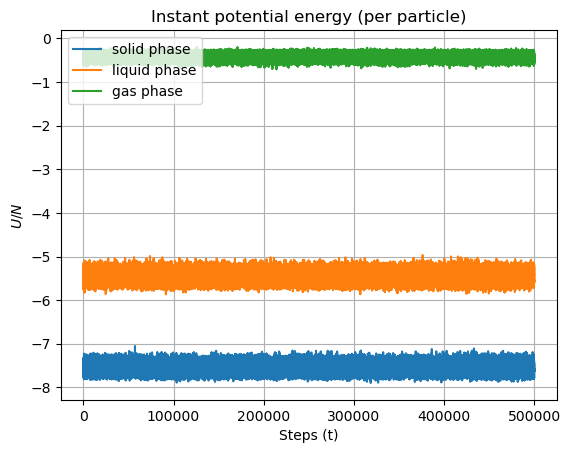

In [18]:
for i in range(len(tags)):
    plt.plot(np.linspace(1,data_size,data_size), pot_energy[i], label= tags[i] + ' phase')
plt.xlabel('Steps (t)')
plt.ylabel('$U/N$')
plt.legend(loc="upper left")
plt.grid(True)
plt.title('Instant potential energy (per particle)')
plt.show()

### Autocorrelation function

We define the **covariance** between two random variables as follow:
$$
cov_{[x_i,x_j]}(t_1, t_2)= \langle x_1(t_1)x_2(t_2) \rangle - \langle x_1(t_1) \rangle \langle x_2(t_2) \rangle
$$

We can then define the autocorrelation function of a random process as the statistical covariance of the process with a time-delayed copy of itself:
$$
Ac_{[x]}(\tau)= \frac{cov_{[x,x]}(t, t+\tau)}{cov_{[x,x]}(t, t)}
$$
as function of a lag time $\tau>0$.

The autocorrelation function can therefore be used to investigate the presence of memory or statistical dependence in a process. In particluar, we wish to evaluate how big blocks need to de in order for them to be nearly independent from one another.

We will use the statsmodel.api module to calculate the autocorrelation for each phase from the data above.

In [4]:
def exponential(x, a, b):
    return a * np.exp(-b * x)

solid  phase:  tau_c fit =  8.307146384398774
liquid  phase:  tau_c fit =  9.487815144868927
gas  phase:  tau_c fit =  2.1058731715875916


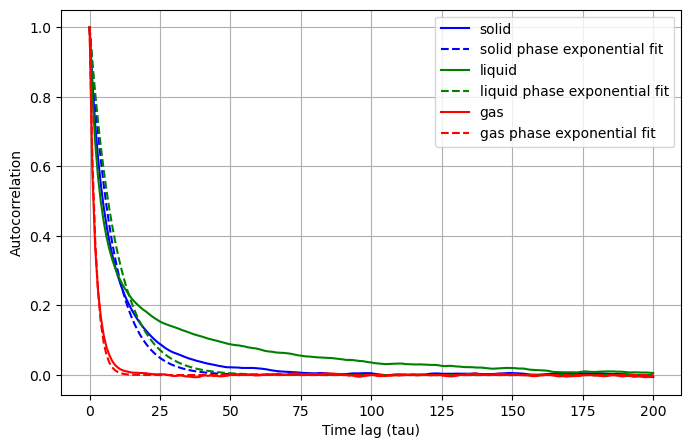

In [22]:
plt.figure(figsize=(8,5))
colors=['b', 'g', 'r']
for i in range(len(tags)):
    autocorr= sm.tsa.acf(pot_energy[i], nlags = 200)   # autocorrelation (array)
    x= np.arange(len(autocorr))
    plt.plot(x, autocorr, label=tags[i], c=colors[i])
    
    #exponential fit
    popt, pcov = curve_fit(exponential, x, autocorr, bounds = ([1, 0], [np.inf, np.inf])) 
    a_fit, b_fit = popt   # popt is array of optimized parameters
    print(tags[i],' phase: ','tau_c fit = ', str(1/b_fit))
    
    plt.plot(x, exponential(x, 1, b_fit), label= tags[i]+' phase exponential fit', c=colors[i], ls = 'dashed')
    
plt.legend(loc='upper right')
plt.xlabel('Time lag (tau)')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

An exponential fit of the type $f(\tau)=exp(-t/\tau_c)$ has been applied.

We can see that the autocorrelation dies off rather quickly, especially for the more "disordered" gas phase.

### Statistical uncertainties

To highlight the importance of data blocking, we show how the statistical uncertainties depend on the block size L.
From the same data, for each block size ranging from 1 to 3000, we "pack" the data in blocks of that size and calculate the statistical uncertainty using data blocking.

In [7]:
def error(data):  # Function for statistical uncertainty estimation
    data_squared=data**2
    return(np.sqrt((np.average(data_squared)-np.average(data)**2)/len(data)))

def compute_errors(data, max_block_size):
    errors=np.zeros(max_block_size)
    data_size=len(data)
    for block_size in range(1,max_block_size+1):
        block_data=np.zeros(int(data_size/block_size))
        for block in range(int(data_size/block_size)):
            initial=block_size*block
            final=initial+block_size
            block_data[block]=np.sum(data[initial:final])/block_size   # computes average over a single block
        errors[block_size-1]=error(block_data)
    return errors

In [9]:
max_block_size=3000

phase_err=[0,0,0]

for i in range(len(tags)):
    phase_err[i]=compute_errors(pot_energy[i],max_block_size)

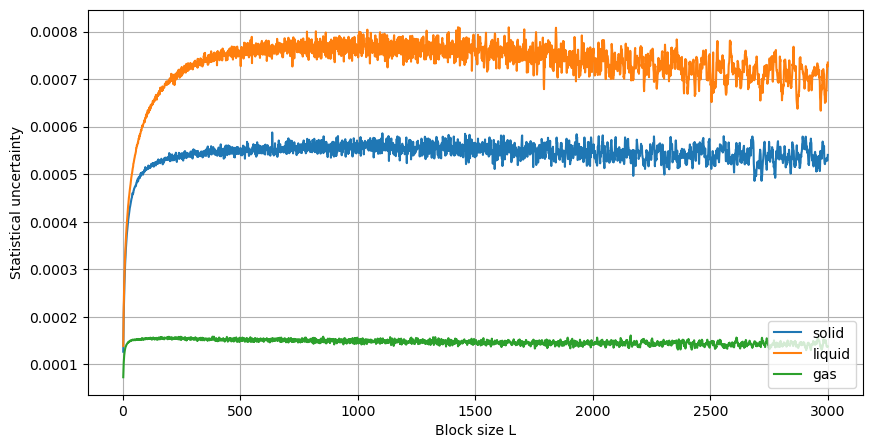

In [23]:
plt.figure(figsize=(10,5))

for i in range(len(tags)):
    plt.plot(np.linspace(1, max_block_size, max_block_size), phase_err[i], label=tags[i])
plt.legend(loc='lower right')
plt.xlabel('Block size L')
plt.ylabel('Statistical uncertainty')
plt.grid(True)
plt.show()

As we can clearly see, smaller blocks result in an underestimation of the statistical uncertainty, since each single data point (i.e. each block) is correlated with the neighboring ones, as shown in the autocorrelation plot.

# 7.3: Radial distribution function $g(r)$

We aim to include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$  (where L is the side of the cell of volume V defined by the simulation parameters) inside the NSL simulator code.

The radial distribution function describes the probability of finding a pair of atoms at a distance $r$ apart from each other, relative to the probability expected for a completely random distribution of the same density.

For the system we are studying, it can be calculated as:
$$
g(r) = \frac{1}{\rho N \Delta V(r)} \left\langle \sum \sum_{i\neq j}^N \delta(r-|\vec{r}_i -\vec{r}_j|) \right\rangle
$$

where $\Delta V(r)=\frac{4\pi}{3}[(r+dr)^3-r^3]$  is the volume of the spherical shell of tickness $dr$.

The plot below shows the $g(r)$ obtained with a MC simulation performed at the equilibrium with 50 blocks of 2000 steps each.

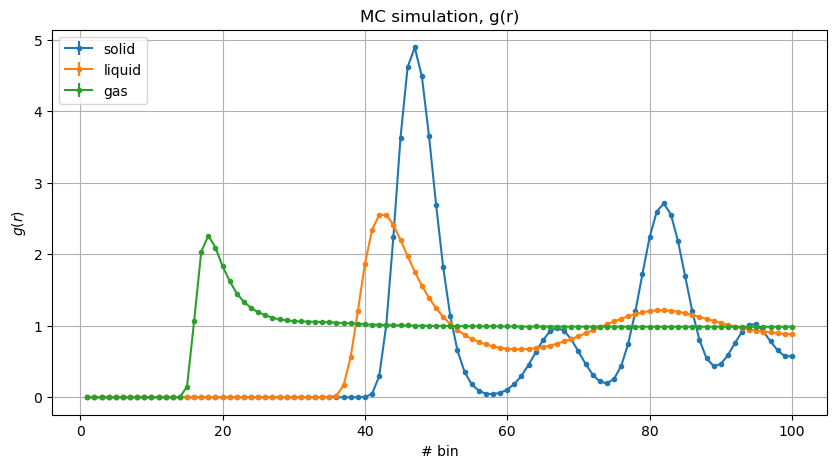

In [74]:
plt.figure(figsize=(10,5))
for i in range(len(tags)):
    radius, gofr, gofr_err =np.loadtxt('../es7/7.4/' +tags[i] +'/gofr_MC.dat', usecols=(0,1,2), unpack=True)
    plt.errorbar(np.arange(1,101), gofr, gofr_err, label=tags[i], marker='.')
plt.legend(loc='upper left')
plt.xlabel('# bin')
plt.ylabel('$g(r)$')
plt.title('MC simulation, g(r)')
plt.grid(True)
plt.show()

This graph allowes us to appreciate the different characteristic radial distribution of each phase.
The solid phase privileges a crystal-like structure, with more defined "shells", whereas the gas phase is more disordered, with the only privileged radial distance being the one that coincides with the minimum of the interaction potential.

NOTE: the size of bins from distinct phases differs ...

# 7.4: final results

Again, the parameters are:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$, $\delta=0.06$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$, $\delta=0.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$, $\delta=10$ (cut-off radius: $r_c = 5.0$)

Each simulation is performed at the equilibrium using 50 blocks of 2000 steps.


We show below the results of measurements for potential energy per particle, $U/N$, pressure $P$ and radial distribution function $g(r)$ in LJ units, along with a comparison between the values of $g(r)$ obtained with MC NVT and Molecular Dynamics NVE simulations.

## Solid phase

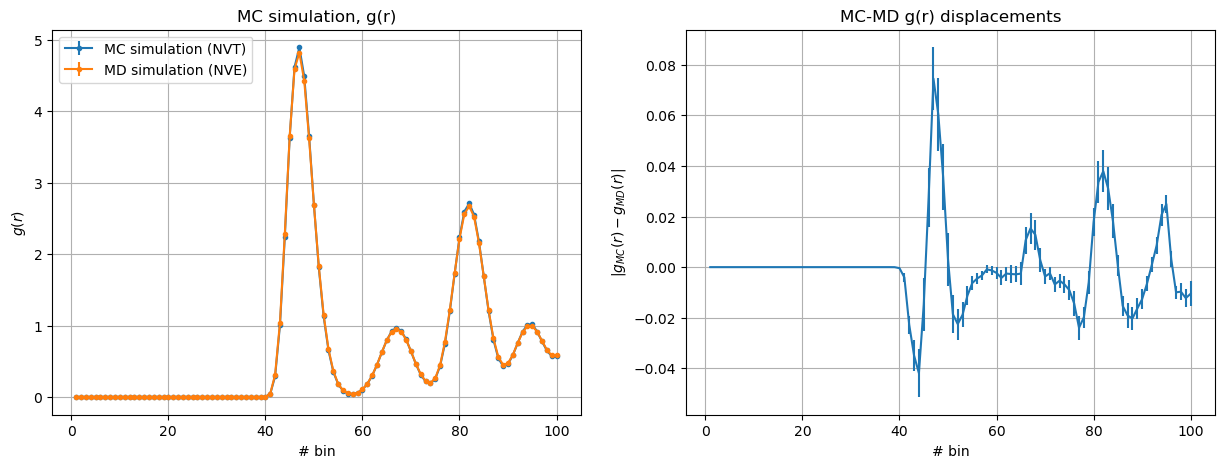

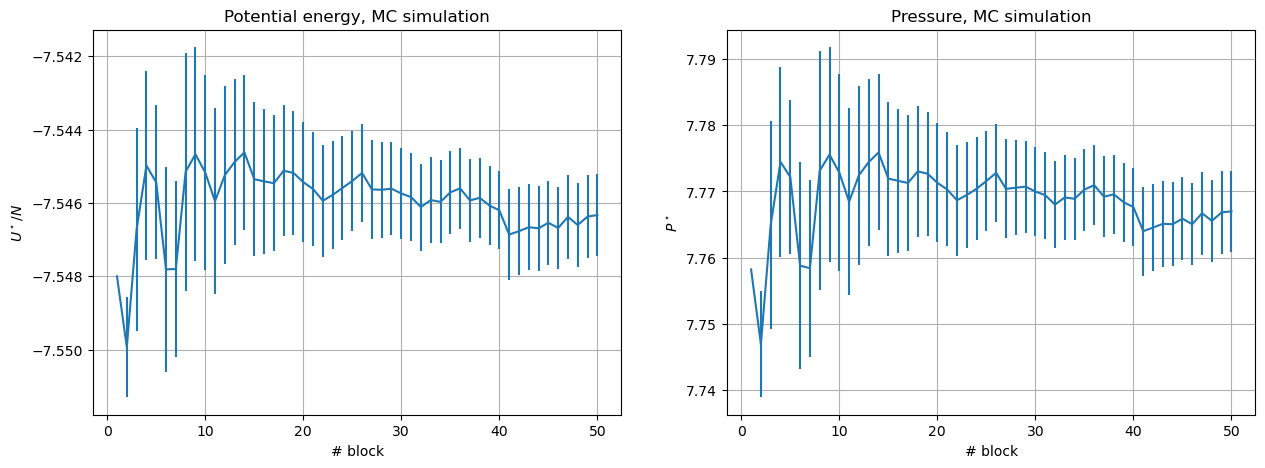

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

gofr_MC, gofr_MC_err =np.loadtxt('../es7/7.4/solid/gofr_MC.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MC, gofr_MC_err, label='MC simulation (NVT)', marker='.')
gofr_MD, gofr_MD_err =np.loadtxt('../es7/7.4/solid/gofr_MD.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MD, gofr_MD_err, label='MD simulation (NVE)', marker='.')

axs[1].errorbar(np.arange(1,101), gofr_MC-gofr_MD, gofr_MC_err+gofr_MD_err)

axs[0].legend(loc='upper left')
axs[0].set_xlabel('# bin')
axs[0].set_ylabel('$g(r)$')
axs[0].set_title('MC simulation, g(r)')
axs[0].grid(True)
#axs[1].legend(loc='upper left')
axs[1].set_xlabel('# bin')
axs[1].set_ylabel('$|g_{MC}(r)-g_{MD}(r)|$')
axs[1].set_title('MC-MD g(r) displacements')
axs[1].grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

x, potential_energy, pot_en_err =np.loadtxt('../es7/7.4/solid/potential_energy.dat', usecols=(0,2,3), unpack=True)
axs[0].errorbar(x, potential_energy, pot_en_err, label='MC simulation (NVT)')
axs[0].set_xlabel('# block')
axs[0].set_ylabel('$U^\star/N$')
axs[0].set_title('Potential energy, MC simulation')
axs[0].grid(True)

x, pressure, pressure_err =np.loadtxt('../es7/7.4/solid/pressure.dat', usecols=(0,2,3), unpack=True)
axs[1].errorbar(x, pressure, pressure_err, label='MC simulation (NVT)')
axs[1].set_xlabel('# block')
axs[1].set_ylabel('$P^\star$')
axs[1].set_title('Pressure, MC simulation')
axs[1].grid(True)

plt.show()

## Liquid phase

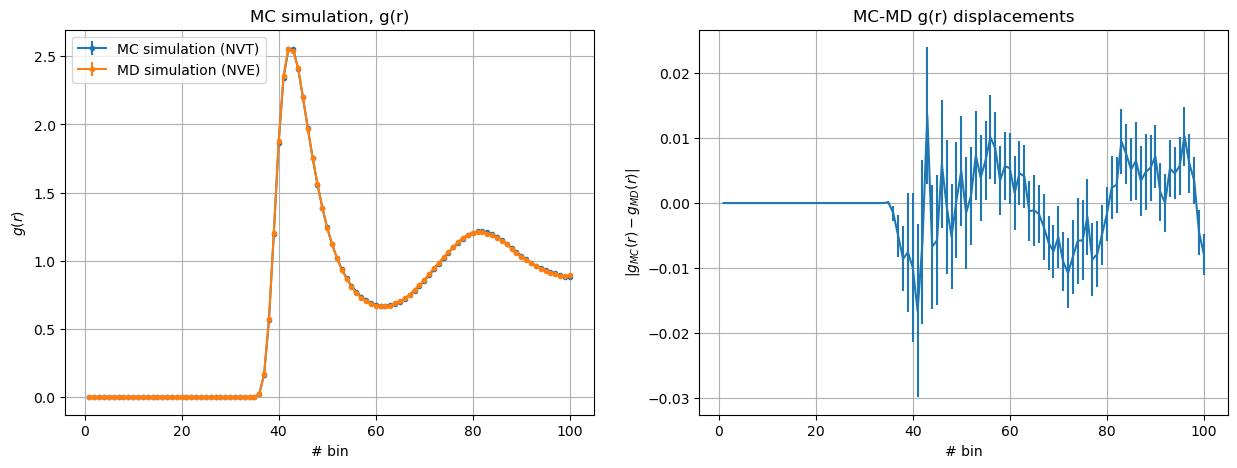

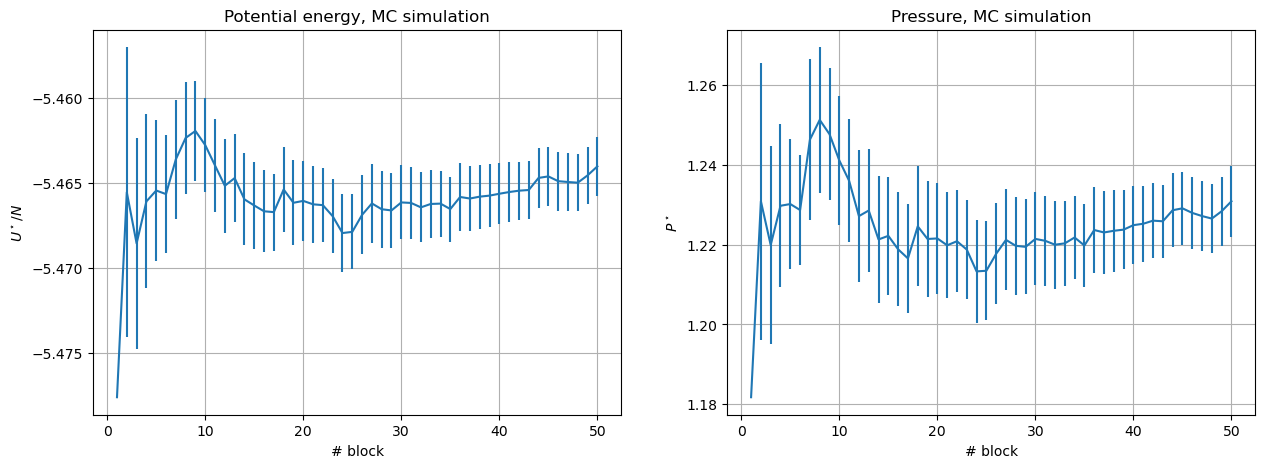

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

gofr_MC, gofr_MC_err =np.loadtxt('../es7/7.4/liquid/gofr_MC.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MC, gofr_MC_err, label='MC simulation (NVT)', marker='.')
gofr_MD, gofr_MD_err =np.loadtxt('../es7/7.4/liquid/gofr_MD.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MD, gofr_MD_err, label='MD simulation (NVE)', marker='.')

axs[1].errorbar(np.arange(1,101), gofr_MC-gofr_MD, gofr_MC_err+gofr_MD_err)

axs[0].legend(loc='upper left')
axs[0].set_xlabel('# bin')
axs[0].set_ylabel('$g(r)$')
axs[0].set_title('MC simulation, g(r)')
axs[0].grid(True)
#axs[1].legend(loc='upper left')
axs[1].set_xlabel('# bin')
axs[1].set_ylabel('$|g_{MC}(r)-g_{MD}(r)|$')
axs[1].set_title('MC-MD g(r) displacements')
axs[1].grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

x, potential_energy, pot_en_err =np.loadtxt('../es7/7.4/liquid/potential_energy.dat', usecols=(0,2,3), unpack=True)
axs[0].errorbar(x, potential_energy, pot_en_err, label='MC simulation (NVT)')
axs[0].set_xlabel('# block')
axs[0].set_ylabel('$U^\star/N$')
axs[0].set_title('Potential energy, MC simulation')
axs[0].grid(True)

x, pressure, pressure_err =np.loadtxt('../es7/7.4/liquid/pressure.dat', usecols=(0,2,3), unpack=True)
axs[1].errorbar(x, pressure, pressure_err, label='MC simulation (NVT)')
axs[1].set_xlabel('# block')
axs[1].set_ylabel('$P^\star$')
axs[1].set_title('Pressure, MC simulation')
axs[1].grid(True)

plt.show()

## Gas phase

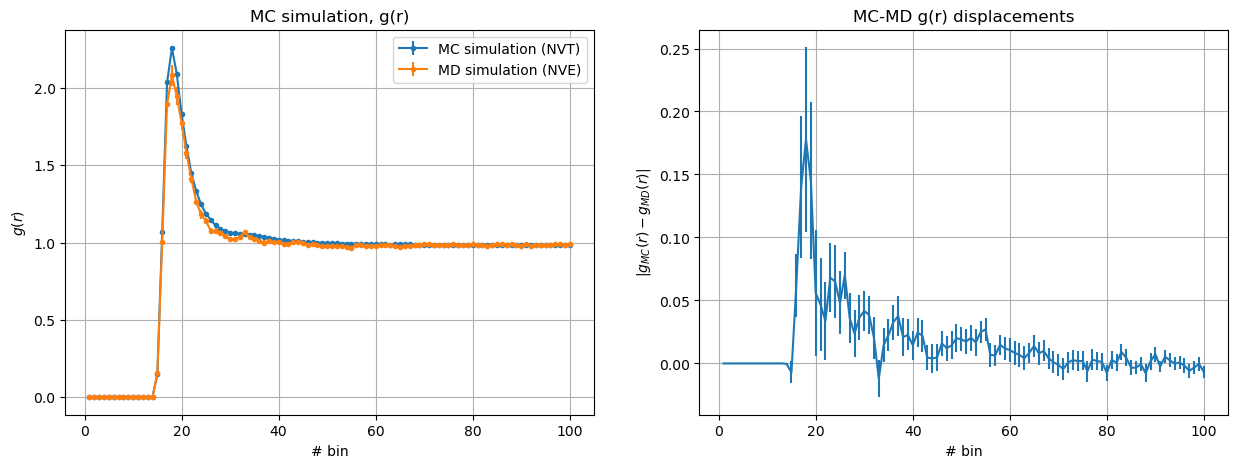

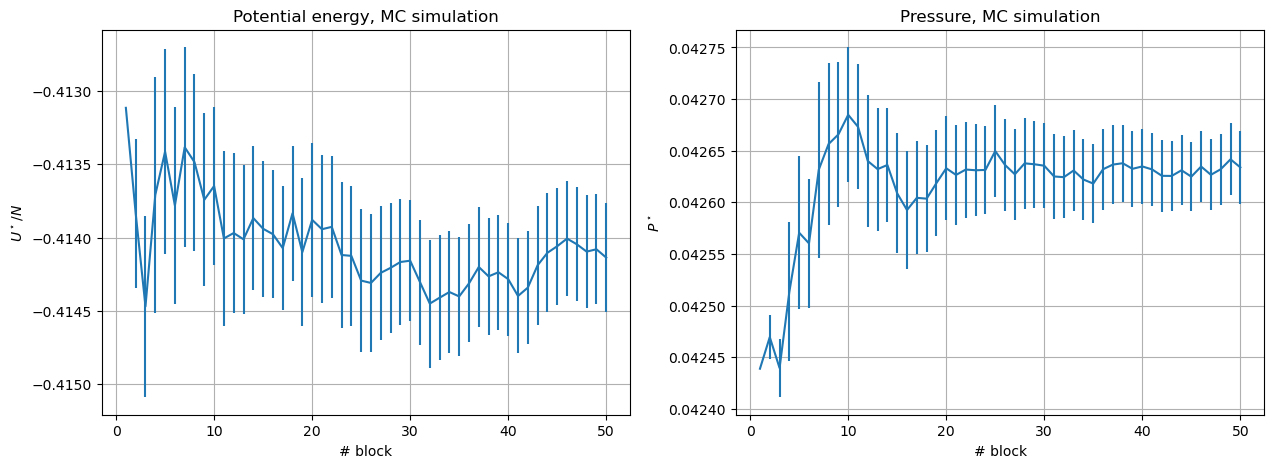

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))

gofr_MC, gofr_MC_err =np.loadtxt('../es7/7.4/gas/gofr_MC.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MC, gofr_MC_err, label='MC simulation (NVT)', marker='.')
gofr_MD, gofr_MD_err =np.loadtxt('../es7/7.4/gas/gofr_MD.dat', usecols=(1,2), unpack=True)
axs[0].errorbar(np.arange(1,101), gofr_MD, gofr_MD_err, label='MD simulation (NVE)', marker='.')

axs[1].errorbar(np.arange(1,101), gofr_MC-gofr_MD, gofr_MC_err+gofr_MD_err)

axs[0].legend(loc='upper right')
axs[0].set_xlabel('# bin')
axs[0].set_ylabel('$g(r)$')
axs[0].set_title('MC simulation, g(r)')
axs[0].grid(True)
#axs[1].legend(loc='upper left')
axs[1].set_xlabel('# bin')
axs[1].set_ylabel('$|g_{MC}(r)-g_{MD}(r)|$')
axs[1].set_title('MC-MD g(r) displacements')
axs[1].grid(True)
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (15, 5))

x, potential_energy, pot_en_err =np.loadtxt('../es7/7.4/gas/potential_energy.dat', usecols=(0,2,3), unpack=True)
axs[0].errorbar(x, potential_energy, pot_en_err, label='MC simulation (NVT)')
axs[0].set_xlabel('# block')
axs[0].set_ylabel('$U^\star/N$')
axs[0].set_title('Potential energy, MC simulation')
axs[0].grid(True)

x, pressure, pressure_err =np.loadtxt('../es7/7.4/gas/pressure.dat', usecols=(0,2,3), unpack=True)
axs[1].errorbar(x, pressure, pressure_err, label='MC simulation (NVT)')
axs[1].set_xlabel('# block')
axs[1].set_ylabel('$P^\star$')
axs[1].set_title('Pressure, MC simulation')
axs[1].grid(True)

plt.show()